In [1]:
#%%capture
#@title
#Installing qiskit standalone
!pip install imgaug==0.2.5
#!pip install qiskit==0.36.1
!pip install qiskit -U
!pip install pylatexenc
#Next lines for LaTeX
!pip install latex
!apt-get install cm-super
!apt-get install dvipng 
!apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 562 kB 5.2 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-py3-none-any.whl size=561438 sha256=ab5fe8cdd9a9786f978c989abe9989e12e917f2d01ec72efd416338044045e88
  Stored in directory: /root/.cache/pip/wheels/60/dd/38/d1dc2cad2b6a66dc0249261004990bccb0f27985c74ba26e49
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 5.4 MB/s 
     |████████████████████████████████| 18.0 MB 291 kB/s 
     |████████████████████████████████| 240 kB 50.6 MB/s 
     |████████████████████████████████| 112 kB 54.9 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████

In [2]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram

import qiskit.quantum_info as qi

from scipy import linalg as lng
import matplotlib.pyplot as plt

In [3]:
svsim = Aer.get_backend('statevector_simulator')
qc = QuantumCircuit(1,1)

#the state used to initialize is always the same when using the simulator
#all the 20'000 shots use the very same state (this does not occur when using a real backend)
#we should see 70% of |1> and 30% of |0>, when no noise is in place (sqrt(0.7)^2, (sqrt(0.3)^2) )
#ideal machine: state p(|0>) = 70%
#real machine: state p(|0>) = 0.7*(0.7) + 0.3*1

qc.initialize([np.sqrt(0.7), 1j*np.sqrt(0.3) ], 0) #initializing qubit 0 with values [ sqrt(0.7), i*sqrt(0.3) ]

result = execute(qc, shots=20000, backend =svsim).result()
svector = result.get_statevector()
print(svector)

Statevector([0.83666003+0.j        , 0.        +0.54772256j],
            dims=(2,))


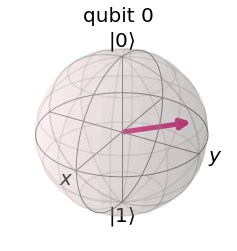

In [4]:
plot_bloch_multivector(svector)

In [5]:
#we need an array with shape (1,2)...
psil = np.array([svector])
psil.shape

(1, 2)

In [6]:
print(psil)

[[0.83666003+0.j         0.        +0.54772256j]]


In [7]:
psil = np.array([svector])
psic = np.conjugate(psil).T
print(psil)
print(psic)

[[0.83666003+0.j         0.        +0.54772256j]]
[[0.83666003-0.j        ]
 [0.        -0.54772256j]]


In [8]:
rho = psic@psil # density operator with p=100%
print(rho) #density operator

[[0.7+0.j         0. +0.45825757j]
 [0. -0.45825757j 0.3+0.j        ]]


In [9]:
#This state is a pure state (as expected) as the resulting trace of rho^2 = 1
print(np.trace(rho@rho))

(1+0j)


In [10]:
#computational basis...
v0 = np.array([[1,0]])
v1 = np.array([[0,1]])

In [11]:
#distinct projections... 
#the projection below gives the element of rho in line 2, column 2 - in python: [1, 1]
print(np.conjugate(v1)@rho@v1.T)  #<1|rho|1>
print(rho[1,1])
print()
#distinct projections... 
#the projection below gives the element of rho in line 1, column 1 - in python: [0, 0]
print(np.conjugate(v0)@rho@v0.T)  #<0|rho|0>
print(rho[0,0])
print()
#distinct projections... 
#the projection below gives the element of rho in line 1, column 2 - in python: [0, 1]
print(np.conjugate(v0)@rho@v1.T)  #<0|rho|1>
print(rho[0,1])

[[0.3+0.j]]
(0.29999999999999993+0j)

[[0.7+0.j]]
(0.7000000000000001+0j)

[[0.+0.45825757j]]
0.458257569495584j


In [12]:
#Computer NOT ideal - 80% is sending rho, 20% is sending state |1> 
rhof = 0.8*rho + 0.2*v1.T@v1
rhof

array([[0.56+0.j        , 0.  +0.36660606j],
       [0.  -0.36660606j, 0.44+0.j        ]])

In [13]:
#Trace of rhof is related to the probability - and must be 1 = 100%
np.trace(rhof)

(1+0j)

In [14]:
#Here we can see the mix of the state... trace(rho^2) < 1
np.trace(rhof@rhof) # mixed state - returns value < 1

(0.776+0j)

In [15]:
#if we know from rho the element e00, e01, e10, we can define entirely rho as e11=1-e00
#How to re-construct the quantum state ?

In [16]:
ident = np.identity(2)
sx = np.array([[ 0, 1],  [1, 0]])
sy = np.array([[ 0,-1j], [1j,0]])
sz = np.array([[ 1, 0],  [0,-1]])

In [17]:
a = np.trace(sx@rho)
b = np.trace(sy@rho)
c = np.trace(sz@rho)
#print(np.trace(sx@rho/2))
#print(np.trace(sy@rho/2))
#print(np.trace(sz@rho/2))
print(a)
print(b)
print(c)

0j
(-0.916515138991168+0j)
(0.40000000000000013+0j)


In [18]:
print(rho)

[[0.7+0.j         0. +0.45825757j]
 [0. -0.45825757j 0.3+0.j        ]]


In [19]:
#rebuilding the state...
#rho = Identity/2 + Identity/2@(a*Sx + b*Sy + c*Sz)
rho2 = ident/2 + ident/2@( a*sx + b*sy + c*sz )
rho2

array([[0.7+0.j        , 0. +0.45825757j],
       [0. -0.45825757j, 0.3+0.j        ]])

In [20]:
simulator = Aer.get_backend('qasm_simulator')
qc = QuantumCircuit(1,1)

qc.initialize([np.sqrt(0.7), 1j*np.sqrt(0.3) ], 0)
qc.measure(0,0)

result = execute(qc, shots=20000, backend =simulator).result()
result.get_counts()

{'0': 13955, '1': 6045}

In [21]:
#This is the expected value of c, when calculating it based on the rho. Note that rho was calculated using the vector state.
#Trace(Sz@rho) = c
np.trace(sz@rho)

(0.40000000000000013+0j)

In [22]:
#The Trace(Sz@rho) can be calculated indirectly by looking at what was observed as the outcome of the shots.
#Trace(Sz@rho) = p(|1>) - p(|0>)
# using values obtained in the simulator:
counts = result.get_counts()
tcounts = counts['0'] + counts['1']
c = counts['0']/tcounts - counts['1']/tcounts
c
#note the value below is very close to the value calculated above, using the original rho
#the diference is due to the stochastic nature of the second calculation

0.39549999999999996

In [23]:
#Calculating the values of "a" abd "b"...

In [24]:
psic

array([[0.83666003-0.j        ],
       [0.        -0.54772256j]])

In [25]:
#This is the psic calculated in the computational basis |0> , |1>
0.83666003*v0.T  -0.54772256j*v1.T

array([[0.83666003+0.j        ],
       [0.        -0.54772256j]])

In [26]:
#Now, lets represent the basis |+> and |->
vp = (1/np.sqrt(2))*(v0+v1)
vn = (1/np.sqrt(2)*(v0-v1))
print(vp)
print(vn)

[[0.70710678 0.70710678]]
[[ 0.70710678 -0.70710678]]


In [27]:
#Projecting the psic to the vectors vn and vp to find the "a" and "b" for the basis |->, |+>
aa = vn@psic
bb = vp@psic
print(aa)
print(bb)

[[0.59160798+0.38729833j]]
[[0.59160798-0.38729833j]]


In [28]:
#note the resulting vector has the same values as the original vector psic
bb*vp.T + aa*vn.T

array([[0.83666003+0.j        ],
       [0.        -0.54772256j]])

How to calculate the factor "a" and "b" of the density operator...

In [38]:
simulator = Aer.get_backend('statevector_simulator')
qc = QuantumCircuit(1,1)
qc.initialize([np.sqrt(0.7), 1j*np.sqrt(0.3) ], 0)
qc.measure(0,0)

result = execute(qc, shots=50000, backend =simulator).result()

counts = result.get_counts()
counts

{'0': 34961, '1': 15039}

In [30]:
#Same state used in the quantum circuit above
psil = np.array([[np.sqrt(0.7), +1j*np.sqrt(0.3)]])
psic = np.conjugate(psil).T

rho=psic@psil #density operator
rho

array([[0.7+0.j        , 0. +0.45825757j],
       [0. -0.45825757j, 0.3+0.j        ]])

In [40]:
#Calculating c from the density operator...
c0 = counts['0']
c1 = counts['1']
print(c0)
print(c1)
#Below, the Trace(Sigmaz*rho) = c, printed using the results first and then the original density operator rho 
print((c0)/(c0+c1) - (c1)/(c0+c1))
print(f"Value 'c' that multiplies sz in the density operator: c={np.trace(sz@rho)}")

34961
15039
0.39843999999999996
Value 'c' that multiplies sz in the density operator: (0.40000000000000013+0j)


In [32]:
#Let's look at the state phi = a|+> + b|
# U|psi> = a|0> + b|1>


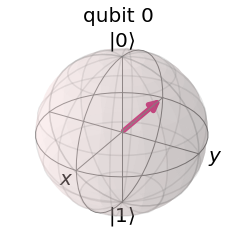

In [43]:
#2:04:23
sim = Aer.get_backend('statevector_simulator')
qc = QuantumCircuit(1,1)
qc.initialize([0,1], 0)
qc.measure(0,0)

#qc.rx(np.pi/2,0) #rotation in "x" by pi/2
qc.ry(np.pi/2,0) #rotation in "y" by pi/2
#qc.ry(np.pi/2,0) #rotation in "y" by pi/2

result = execute(qc, shots=30000, backend = sim).result()
svector = result.get_statevector()
plot_bloch_multivector(svector)

In [44]:
#applying the operation ry before measuring... measuring the expected value of sx
simulator = Aer.get_backend('statevector_simulator')
qc = QuantumCircuit(1,1)
qc.initialize([np.sqrt(0.7), 1j*np.sqrt(0.3) ], 0)
qc.ry(np.pi/2,0) #rotation in "y" by pi/2
qc.measure(0,0)

result = execute(qc, shots=50000, backend =simulator).result()

counts = result.get_counts()
counts

{'0': 25092, '1': 24908}

In [45]:
#Calculating 'a' from the density operator...
c0 = counts['0']
c1 = counts['1']
print(c0)
print(c1)
#Below, the Trace(Sigmax*rho) = a, printed using the results first and then the original density operator rho 
print(0.5*((c0)/(c0+c1) - (c1)/(c0+c1)))
#print(f"Value 'a' that multiplies sx in the density operator: {np.trace(sx@rho)}")

25092
24908
0.003679999999999961


In [46]:
#Now, transformation of basis from |i-> |i+> to |0> e |1>
simulator = Aer.get_backend('statevector_simulator')
qc = QuantumCircuit(1,1)
qc.initialize([np.sqrt(0.7), 1j*np.sqrt(0.3) ], 0)
qc.rx(-np.pi/2,0) #rotation in "x" by pi/2
qc.measure(0,0)

result = execute(qc, shots=50000, backend =simulator).result()

counts = result.get_counts()
counts

{'0': 2105, '1': 47895}

In [48]:
#Calculating 'b' from the density operator...
c0 = counts['0']
c1 = counts['1']
print(c0)
print(c1)
#Below, the Trace(Sigmay*rho) = b, printed using the results first and then the original density operator rho 
print( 0.5*((c0)/(c0+c1) - (c1)/(c0+c1)))
#print(f"Value 'b' that multiplies sy in the density operator: {np.trace(sy@rho)}")

2105
47895
-0.4579


## Summary:
- Running the simulation without any transformation allows the estimation of 'c', where c = trace(sz@rho)
- Running the simulation with a transformation ry($pi$/2,0) allows the estimation of 'a', where a = trace(sx@rho)
- Running the simulation with a transformation rx(-$pi$/2,0) allows the estimation of 'b', where b = trace(sy@rho)

The final density operator $rho$ is given by:
rho = 1/2*Identity + 1/2*Identity*(a*Sx + b*Sy + c*Sz) 


In [49]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram

import qiskit.quantum_info as qi

from scipy import linalg as lng
import matplotlib.pyplot as plt

In [52]:
psil = np.array([[np.sqrt(0.7), +1j*np.sqrt(0.3)]])
psic = np.conjugate(psil).T
rho=psic@psil
print(rho)

[[0.7+0.j         0. +0.45825757j]
 [0. -0.45825757j 0.3+0.j        ]]


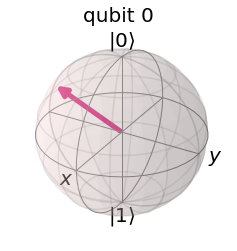

In [53]:
plot_bloch_multivector(qi.DensityMatrix(rho))

### Calculating 'c' = Trace(Sz@rho)

In [77]:
sim = Aer.get_backend("qasm_simulator")
qr = QuantumRegister(3)
crz, crx, crf  = ClassicalRegister(1), ClassicalRegister(1), ClassicalRegister(1)
qc = QuantumCircuit(qr, crz, crx, crf)
qc.initialize([np.sqrt(0.7), +1j*np.sqrt(0.3)], 0)
qc.h(1)
qc.cx(1,2)
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.barrier()
qc.measure(0, crz)
qc.measure(1, crx)

qc.measure(2, crf)

qc.draw()



┌──────────────────────────────┐      ░      ┌───┐ ░ ┌─┐      
q114_0: ┤ Initialize(0.83666,0.54772j) ├──────░───■──┤ H ├─░─┤M├──────
        └────────────┬───┬─────────────┘      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐   
q114_1: ─────────────┤ H ├────────────────■───░─┤ X ├──────░──╫─┤M├───
                     └───┘              ┌─┴─┐ ░ └───┘      ░  ║ └╥┘┌─┐
q114_2: ────────────────────────────────┤ X ├─░────────────░──╫──╫─┤M├
                                        └───┘ ░            ░  ║  ║ └╥┘
 c18: 1/══════════════════════════════════════════════════════╩══╬══╬═
                                                              0  ║  ║ 
                                                                 ║  ║ 
 c19: 1/═════════════════════════════════════════════════════════╩══╬═
                                                                 0  ║ 
                                                                    ║ 
 c20: 1/════════════════════════════════════════════════════════════╩═
                                                                    0

In [78]:
result = execute(qc, shots=20000, backend = sim).result()
counts = result.get_counts()
counts

{'0 0 0': 3529,
 '0 0 1': 3466,
 '0 1 0': 1477,
 '0 1 1': 1508,
 '1 0 0': 1471,
 '1 0 1': 1477,
 '1 1 0': 3585,
 '1 1 1': 3487}

In [79]:
#Above we can pick only the rows with values '0 0 0' and '1 0 0'
#using them, there is no need to apply bit flip or phase flip
r0 = counts['0 0 0']
r1 = counts['1 0 0']
c = (r0-r1)/(r0+r1) #Trace(sz@rho)
c

0.41159999999999997

In [80]:
#This is part of rho, only considering sz
rho = 0.5*ident + 0.5*(c*sz)
rho

array([[0.7058, 0.    ],
       [0.    , 0.2942]])

### Calculating 'a' = Trace(Sx@rho)

In [91]:
#To find 'a'... we need rotation before the measure ry(pi(2,0))

sim = Aer.get_backend("qasm_simulator")
qr = QuantumRegister(3)
crz, crx, crf  = ClassicalRegister(1), ClassicalRegister(1), ClassicalRegister(1)
qc = QuantumCircuit(qr, crz, crx, crf)
qc.initialize([np.sqrt(0.7), +1j*np.sqrt(0.3)], 0)
qc.h(1)
qc.cx(1,2)
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.barrier()
qc.measure(0, crz)
qc.measure(1, crx)

#Adding the rotation to find 'a'
qc.ry(np.pi/2,2)
qc.measure(2, crf)

qc.draw()

┌──────────────────────────────┐      ░      ┌───┐ ░ ┌─┐              »
q151_0: ┤ Initialize(0.83666,0.54772j) ├──────░───■──┤ H ├─░─┤M├──────────────»
        └────────────┬───┬─────────────┘      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐           »
q151_1: ─────────────┤ H ├────────────────■───░─┤ X ├──────░──╫─┤M├───────────»
                     └───┘              ┌─┴─┐ ░ └───┘      ░  ║ └╥┘┌─────────┐»
q151_2: ────────────────────────────────┤ X ├─░────────────░──╫──╫─┤ Ry(π/2) ├»
                                        └───┘ ░            ░  ║  ║ └─────────┘»
 c27: 1/══════════════════════════════════════════════════════╩══╬════════════»
                                                              0  ║            »
 c28: 1/═════════════════════════════════════════════════════════╩════════════»
                                                                 0            »
 c29: 1/══════════════════════════════════════════════════════════════════════»
                                                                              »
«           
«q151_0: ───
«           
«q151_1: ───
«        ┌─┐
«q151_2: ┤M├
«        └╥┘
« c27: 1/═╬═
«         ║ 
« c28: 1/═╬═
«         ║ 
« c29: 1/═╩═
«         0

In [92]:
result = execute(qc, shots=20000, backend = sim).result()
counts = result.get_counts()
counts

{'0 0 0': 2492,
 '0 0 1': 2513,
 '0 1 0': 2540,
 '0 1 1': 2480,
 '1 0 0': 2537,
 '1 0 1': 2558,
 '1 1 0': 2388,
 '1 1 1': 2492}

In [94]:
#Above we can pick only the rows with values '0 0 0' and '1 0 0'
#using them, there is no need to apply bit flip or phase flip
r0 = counts['0 0 0']
r1 = counts['1 0 0']
a= (r0-r1)/(r0+r1) #Trace(sx@rho)
a

-0.008948101014118115

In [95]:
#This is part of rho, now considering sx and sz
rho = 0.5*ident + 0.5*(a*sx + c*sz)
rho

array([[ 0.7058    , -0.00447405],
       [-0.00447405,  0.2942    ]])

### Calculating 'b' = Trace(Sy@rho)

In [96]:
#####Finaly to find 'b'... we need rotation before the measure rx(-pi(2,0))

sim = Aer.get_backend("qasm_simulator")
qr = QuantumRegister(3)
crz, crx, crf  = ClassicalRegister(1), ClassicalRegister(1), ClassicalRegister(1)
qc = QuantumCircuit(qr, crz, crx, crf)
qc.initialize([np.sqrt(0.7), +1j*np.sqrt(0.3)], 0)
qc.h(1)
qc.cx(1,2)
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.barrier()
qc.measure(0, crz)
qc.measure(1, crx)

#Adding the rotation to find 'a'
qc.rx(-np.pi/2,2)
qc.measure(2, crf)

qc.draw()

┌──────────────────────────────┐      ░      ┌───┐ ░ ┌─┐               »
q164_0: ┤ Initialize(0.83666,0.54772j) ├──────░───■──┤ H ├─░─┤M├───────────────»
        └────────────┬───┬─────────────┘      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐            »
q164_1: ─────────────┤ H ├────────────────■───░─┤ X ├──────░──╫─┤M├────────────»
                     └───┘              ┌─┴─┐ ░ └───┘      ░  ║ └╥┘┌──────────┐»
q164_2: ────────────────────────────────┤ X ├─░────────────░──╫──╫─┤ Rx(-π/2) ├»
                                        └───┘ ░            ░  ║  ║ └──────────┘»
 c30: 1/══════════════════════════════════════════════════════╩══╬═════════════»
                                                              0  ║             »
 c31: 1/═════════════════════════════════════════════════════════╩═════════════»
                                                                 0             »
 c32: 1/═══════════════════════════════════════════════════════════════════════»
                                                                               »
«           
«q164_0: ───
«           
«q164_1: ───
«        ┌─┐
«q164_2: ┤M├
«        └╥┘
« c30: 1/═╬═
«         ║ 
« c31: 1/═╬═
«         ║ 
« c32: 1/═╩═
«         0

In [97]:
result = execute(qc, shots=20000, backend = sim).result()
counts = result.get_counts()
counts

{'0 0 0': 201,
 '0 0 1': 4760,
 '0 1 0': 4849,
 '0 1 1': 199,
 '1 0 0': 4830,
 '1 0 1': 232,
 '1 1 0': 224,
 '1 1 1': 4705}

In [100]:
#Above we can pick only the rows with values '0 0 0' and '1 0 0'
#using them, there is no need to apply bit flip or phase flip
r0 = counts['0 0 0']
r1 = counts['1 0 0']
b= (r0-r1)/(r0+r1) #Trace(sy@rho)
b

-0.9200954084675015

In [101]:
#This is part of rho, now considering sx, sy and sz
rho = 0.5*ident + 0.5*(a*sx + b*sy + c*sz)
rho

array([[ 0.7058    +0.j       , -0.00447405+0.4600477j],
       [-0.00447405-0.4600477j,  0.2942    +0.j       ]])

In [102]:
#you now can compare the - reconstructed - state above with the original state...
psil = np.array([[np.sqrt(0.7), +1j*np.sqrt(0.3)]])
psic = np.conjugate(psil).T
rho=psic@psil
print(rho)

[[0.7+0.j         0. +0.45825757j]
 [0. -0.45825757j 0.3+0.j        ]]


In [103]:
np.trace(rho@rho) #should give 1 due to the sum of probabilities

(1+0j)